# <font color='blue'>Imports </font>

In [1]:
%%time
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm
import optuna
import optuna.integration.lightgbm as lgb
import matplotlib.lines as line
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rc
import sklearn.datasets as skd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss, brier_score_loss

Wall time: 1.53 s


In [8]:
%%time
path = 'D:\\Documents\\GitHub\\Classification_datascience\\webscrapping\\matches\\rounds\\'
dataset = pd.read_csv('{}combined_csv.csv'.format(path))

Wall time: 396 ms


In [9]:
dataset.columns

Index(['RoundID', 'RoundNumber', 'RoundTime', 'ATK_wealth', 'DEF_wealth',
       'ATK_alive', 'DEF_alive', 'DEF_has_OP', 'Def_has_Odin', 'RegularTime',
       'SpikeTime', 'ATK_bank', 'DEF_bank', 'ATK_initiators', 'ATK_duelists',
       'ATK_sentinels', 'ATK_controllers', 'DEF_initiators', 'DEF_duelists',
       'DEF_sentinels', 'DEF_controllers', 'MapName', 'MatchID', 'SeriesID',
       'bestOF', 'FinalWinner'],
      dtype='object')

In [10]:
dataset = dataset[['ATK_wealth', 'DEF_wealth',
                   'ATK_initiators', 'ATK_duelists', 'ATK_sentinels', 'ATK_controllers',
                   'DEF_initiators', 'DEF_duelists', 'DEF_sentinels', 'DEF_controllers',
                   'DEF_has_OP', 'Def_has_Odin',
                    'RegularTime', 'SpikeTime',
                   'MapName',
                   'FinalWinner']]

In [11]:
dataset = pd.get_dummies(dataset, columns=['MapName'])

In [12]:
dataset.head()

,ATK_wealth,DEF_wealth,ATK_initiators,ATK_duelists,ATK_sentinels,ATK_controllers,DEF_initiators,DEF_duelists,DEF_sentinels,DEF_controllers,...,Def_has_Odin,RegularTime,SpikeTime,FinalWinner,MapName_Ascent,MapName_Bind,MapName_Breeze,MapName_Haven,MapName_Icebox,MapName_Split
0,500.0,0.0,1,2,1,1,1,1,2,1,...,0,0,0,0,0,0,0,1,0,0
1,500.0,0.0,1,2,1,1,1,0,2,1,...,0,21,0,0,0,0,0,1,0,0
2,400.0,0.0,1,1,1,1,1,0,2,1,...,0,22,0,0,0,0,0,1,0,0
3,300.0,0.0,1,0,1,1,1,0,2,1,...,0,24,0,0,0,0,0,1,0,0
4,200.0,0.0,0,0,1,1,1,0,2,1,...,0,26,0,0,0,0,0,1,0,0


In [13]:
X = dataset.drop(['FinalWinner'], axis='columns')
Y = dataset.FinalWinner

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=15)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, train_size=0.9, test_size=0.1, random_state=15)

# <font color='blue'>Parameter tuning </font>

In [14]:
def objective(trial):
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',2,70),
    num_threads = trial.suggest_int('num_threads',1,10),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    
    model = lightgbm.LGBMClassifier(bagging_freq=bagging_freq,
                                    min_data_in_leaf=min_data_in_leaf,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   num_leaves=num_leaves,
                                   num_threads=num_threads,
                                   min_sum_hessian_in_leaf=min_sum_hessian_in_leaf)
    model.fit(X_train,Y_train)
    pred_proba_test = model.predict_proba(X_test)
    score = brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])
    return score

In [15]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2021-06-18 20:42:08,863] A new study created in memory with name: no-name-d1013864-4c0c-4803-b86d-b3263defcb85


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-18 20:42:09,633] Trial 0 finished with value: 0.13345302098284365 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 49, 'max_depth': 4, 'learning_rate': 0.07286653076362465, 'num_leaves': 13, 'num_threads': 3, 'min_sum_hessian_in_leaf': 5}. Best is trial 0 with value: 0.13345302098284365.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-18 20:42:10,439] Trial 1 finished with value: 0.14084078455271626 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 55, 'max_depth': 20, 'learning_rate': 0.02507897211331298, 'num_leaves': 23, 'num_threads': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 0 with value: 0.13345302098284365.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-18 20:42:11,263] Trial 2 finished with value: 0.1486473687134053 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 48, 'max_depth': 15, 'learning_rate': 0.018338409676919517, 'num_leaves': 16, 'num_threads': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 0 with value: 0.13345302098284365.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 20:42:13,670] Trial 3 finished with value: 0.13313844344785689 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 11, 'max_depth': 6, 'learning_rate': 0.04254436245886494, 'num_leaves': 47, 'num_threads': 1, 'min_sum_hessian_in_leaf': 5}. Best is trial 3 with value: 0.13313844344785689.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 20:42:14,050] Trial 4 finished with value: 0.20625896084637188 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 51, 'max_depth': 1, 'learning_rate': 0.012149005849527285, 'num_leaves': 55, 'num_threads': 9, 'min_sum_hessian_in_leaf': 9}. Best is trial 3 with value: 0.13313844344785689.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 20:42:14,423] Trial 5 finished with value: 0.17255633318732788 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 73, 'max_depth': 1, 'learning_rate': 0.03910788237138652, 'num_leaves': 16, 'num_threads': 6, 'min_sum_hessian_in_leaf': 9}. Best is trial 3 with value: 0.13313844344785689.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 20:42:15,033] Trial 6 finished with value: 0.16121980390198531 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 85, 'max_depth': 4, 'learning_rate': 0.011656436615678629, 'num_leaves': 67, 'num_threads': 5, 'min_sum_hessian_in_leaf': 8}. Best is trial 3 with value: 0.13313844344785689.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 20:42:15,926] Trial 7 finished with value: 0.16491815187190043 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 97, 'max_depth': 20, 'learning_rate': 0.008560455480042984, 'num_leaves': 36, 'num_threads': 8, 'min_sum_hessian_in_leaf': 4}. Best is trial 3 with value: 0.13313844344785689.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 20:42:16,417] Trial 8 finished with value: 0.23841026065031265 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 84, 'max_depth': 18, 'learning_rate': 0.0022854431305820233, 'num_leaves': 2, 'num_threads': 6, 'min_sum_hessian_in_leaf': 1}. Best is trial 3 with value: 0.13313844344785689.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-18 20:42:17,596] Trial 9 finished with value: 0.14415364034644337 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 27, 'max_depth': 13, 'learning_rate': 0.016326156381223852, 'num_leaves': 62, 'num_threads': 7, 'min_sum_hessian_in_leaf': 9}. Best is trial 3 with value: 0.13313844344785689.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 20:42:20,134] Trial 10 finished with value: 0.12935493001536716 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 4, 'max_depth': 7, 'learning_rate': 0.07937475889321557, 'num_leaves': 48, 'num_threads': 1, 'min_sum_hessian_in_leaf': 1}. Best is trial 10 with value: 0.12935493001536716.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 20:42:22,635] Trial 11 finished with value: 0.12877300350450718 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 3, 'max_depth': 8, 'learning_rate': 0.09778104438425568, 'num_leaves': 46, 'num_threads': 1, 'min_sum_hessian_in_leaf': 1}. Best is trial 11 with value: 0.12877300350450718.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 20:42:25,130] Trial 12 finished with value: 0.1296851325414877 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 2, 'max_depth': 9, 'learning_rate': 0.08140729170953112, 'num_leaves': 41, 'num_threads': 1, 'min_sum_hessian_in_leaf': 1}. Best is trial 11 with value: 0.12877300350450718.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 20:42:26,167] Trial 13 finished with value: 0.1905401743269725 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 20, 'max_depth': 10, 'learning_rate': 0.004199821927014484, 'num_leaves': 53, 'num_threads': 3, 'min_sum_hessian_in_leaf': 2}. Best is trial 11 with value: 0.12877300350450718.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 20:42:28,481] Trial 14 finished with value: 0.12980213732082987 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 3, 'max_depth': 8, 'learning_rate': 0.09574428752649392, 'num_leaves': 28, 'num_threads': 1, 'min_sum_hessian_in_leaf': 1}. Best is trial 11 with value: 0.12877300350450718.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-18 20:42:29,912] Trial 15 finished with value: 0.13238130349255942 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 32, 'max_depth': 12, 'learning_rate': 0.04375955085225524, 'num_leaves': 45, 'num_threads': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 11 with value: 0.12877300350450718.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:42:30,767] Trial 16 finished with value: 0.1286417729892089 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 16, 'max_depth': 6, 'learning_rate': 0.09929201829051462, 'num_leaves': 56, 'num_threads': 4, 'min_sum_hessian_in_leaf': 2}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 20:42:31,435] Trial 17 finished with value: 0.2256274757938213 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 18, 'max_depth': 4, 'learning_rate': 0.0015054803503695578, 'num_leaves': 70, 'num_threads': 4, 'min_sum_hessian_in_leaf': 3}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:42:32,293] Trial 18 finished with value: 0.1798828644252265 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 35, 'max_depth': 6, 'learning_rate': 0.005590638301849611, 'num_leaves': 60, 'num_threads': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:42:33,144] Trial 19 finished with value: 0.13714142259654108 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 13, 'max_depth': 11, 'learning_rate': 0.029456042324748948, 'num_leaves': 33, 'num_threads': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:42:34,649] Trial 20 finished with value: 0.13071579325473612 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 39, 'max_depth': 15, 'learning_rate': 0.05447767615708494, 'num_leaves': 55, 'num_threads': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 20:42:36,057] Trial 21 finished with value: 0.12911409824443254 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 4, 'max_depth': 7, 'learning_rate': 0.08825135690484648, 'num_leaves': 47, 'num_threads': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:42:37,294] Trial 22 finished with value: 0.1300192911547884 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 9, 'max_depth': 5, 'learning_rate': 0.09688775789919848, 'num_leaves': 42, 'num_threads': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 20:42:38,214] Trial 23 finished with value: 0.13051800647335712 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 24, 'max_depth': 9, 'learning_rate': 0.05525307816109322, 'num_leaves': 62, 'num_threads': 4, 'min_sum_hessian_in_leaf': 4}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 20:42:39,001] Trial 24 finished with value: 0.13798523317556532 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 2, 'max_depth': 2, 'learning_rate': 0.08965700208887221, 'num_leaves': 50, 'num_threads': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 20:42:39,741] Trial 25 finished with value: 0.1308697391043101 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 14, 'max_depth': 7, 'learning_rate': 0.062443162534635235, 'num_leaves': 40, 'num_threads': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:42:40,425] Trial 26 finished with value: 0.13362746986215077 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 8, 'max_depth': 3, 'learning_rate': 0.09964975002640283, 'num_leaves': 57, 'num_threads': 3, 'min_sum_hessian_in_leaf': 2}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 20:42:41,250] Trial 27 finished with value: 0.13831047521416084 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 65, 'max_depth': 8, 'learning_rate': 0.025992455192923664, 'num_leaves': 36, 'num_threads': 4, 'min_sum_hessian_in_leaf': 4}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 20:42:42,789] Trial 28 finished with value: 0.12961696168501943 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 26, 'max_depth': 10, 'learning_rate': 0.06369740495288029, 'num_leaves': 67, 'num_threads': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-18 20:42:43,690] Trial 29 finished with value: 0.13661114971788785 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 40, 'max_depth': 5, 'learning_rate': 0.03490709346301129, 'num_leaves': 29, 'num_threads': 3, 'min_sum_hessian_in_leaf': 5}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 20:42:44,490] Trial 30 finished with value: 0.1301158200375063 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 15, 'max_depth': 7, 'learning_rate': 0.06794527493227857, 'num_leaves': 49, 'num_threads': 5, 'min_sum_hessian_in_leaf': 6}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 20:42:47,025] Trial 31 finished with value: 0.1286662578961091 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 4, 'max_depth': 7, 'learning_rate': 0.09823704250795319, 'num_leaves': 52, 'num_threads': 1, 'min_sum_hessian_in_leaf': 1}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:42:49,460] Trial 32 finished with value: 0.12873167980417066 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 7, 'max_depth': 6, 'learning_rate': 0.09970217698148282, 'num_leaves': 51, 'num_threads': 1, 'min_sum_hessian_in_leaf': 2}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:42:51,631] Trial 33 finished with value: 0.1298981301872457 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 21, 'max_depth': 5, 'learning_rate': 0.09902106168274233, 'num_leaves': 59, 'num_threads': 1, 'min_sum_hessian_in_leaf': 2}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 20:42:53,259] Trial 34 finished with value: 0.13909867230147138 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 8, 'max_depth': 3, 'learning_rate': 0.05165518002531491, 'num_leaves': 52, 'num_threads': 1, 'min_sum_hessian_in_leaf': 3}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:42:54,274] Trial 35 finished with value: 0.1403015457827437 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 9, 'max_depth': 9, 'learning_rate': 0.021462819940855846, 'num_leaves': 44, 'num_threads': 3, 'min_sum_hessian_in_leaf': 2}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 20:42:56,942] Trial 36 finished with value: 0.12925307601228592 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 18, 'max_depth': 8, 'learning_rate': 0.07243537941031485, 'num_leaves': 65, 'num_threads': 1, 'min_sum_hessian_in_leaf': 3}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 20:42:58,167] Trial 37 finished with value: 0.13431311699507298 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 59, 'max_depth': 5, 'learning_rate': 0.044741295216124105, 'num_leaves': 53, 'num_threads': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 20:43:00,636] Trial 38 finished with value: 0.13454929343665525 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 30, 'max_depth': 6, 'learning_rate': 0.03466449337348726, 'num_leaves': 57, 'num_threads': 1, 'min_sum_hessian_in_leaf': 4}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 20:43:01,319] Trial 39 finished with value: 0.13606821940484423 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 2, 'max_depth': 3, 'learning_rate': 0.07149111368637441, 'num_leaves': 39, 'num_threads': 3, 'min_sum_hessian_in_leaf': 10}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 20:43:02,274] Trial 40 finished with value: 0.13140493749379922 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 46, 'max_depth': 11, 'learning_rate': 0.051570537809016444, 'num_leaves': 45, 'num_threads': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 20:43:03,718] Trial 41 finished with value: 0.1292139373795982 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 6, 'max_depth': 6, 'learning_rate': 0.09095792536823012, 'num_leaves': 47, 'num_threads': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 16 with value: 0.1286417729892089.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:43:06,224] Trial 42 finished with value: 0.12855000769903946 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 12, 'max_depth': 7, 'learning_rate': 0.09867970710104958, 'num_leaves': 51, 'num_threads': 1, 'min_sum_hessian_in_leaf': 2}. Best is trial 42 with value: 0.12855000769903946.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:43:08,757] Trial 43 finished with value: 0.1285249938580993 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 13, 'max_depth': 8, 'learning_rate': 0.0990560427464879, 'num_leaves': 52, 'num_threads': 1, 'min_sum_hessian_in_leaf': 2}. Best is trial 43 with value: 0.1285249938580993.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:43:10,650] Trial 44 finished with value: 0.1333175415872281 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 13, 'max_depth': 4, 'learning_rate': 0.07017351200207698, 'num_leaves': 52, 'num_threads': 1, 'min_sum_hessian_in_leaf': 3}. Best is trial 43 with value: 0.1285249938580993.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 20:43:11,459] Trial 45 finished with value: 0.12887946946473117 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 21, 'max_depth': 7, 'learning_rate': 0.08221880619038753, 'num_leaves': 63, 'num_threads': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 43 with value: 0.1285249938580993.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:43:14,032] Trial 46 finished with value: 0.12826450269578224 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 15, 'max_depth': 9, 'learning_rate': 0.09957593241877248, 'num_leaves': 57, 'num_threads': 1, 'min_sum_hessian_in_leaf': 2}. Best is trial 46 with value: 0.12826450269578224.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 20:43:15,053] Trial 47 finished with value: 0.13171488406021994 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 16, 'max_depth': 14, 'learning_rate': 0.04510018363057763, 'num_leaves': 56, 'num_threads': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 46 with value: 0.12826450269578224.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 20:43:16,517] Trial 48 finished with value: 0.14524035596644733 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 27, 'max_depth': 9, 'learning_rate': 0.015725402743698328, 'num_leaves': 59, 'num_threads': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 46 with value: 0.12826450269578224.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 20:43:19,075] Trial 49 finished with value: 0.20490124285870231 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 23, 'max_depth': 10, 'learning_rate': 0.0027882449164329565, 'num_leaves': 70, 'num_threads': 1, 'min_sum_hessian_in_leaf': 2}. Best is trial 46 with value: 0.12826450269578224.


Wall time: 1min 10s


In [16]:
trial = study.best_trial
print('accuracy: {}'.format(trial.value))
print('best hyperparameters: {}'.format(trial.params))

accuracy: 0.12826450269578224
best hyperparameters: {'bagging_freq': 2, 'min_data_in_leaf': 15, 'max_depth': 9, 'learning_rate': 0.09957593241877248, 'num_leaves': 57, 'num_threads': 1, 'min_sum_hessian_in_leaf': 2}


In [17]:
pd_param = pd.DataFrame([trial.params])
pd_param.to_csv('model_params.csv', index=False)

# <font color='blue'>Model </font>

In [18]:
%%time
model = lightgbm.LGBMClassifier(bagging_freq=trial.params["bagging_freq"], min_data_in_leaf=trial.params["min_data_in_leaf"],
                                max_depth=trial.params["max_depth"],
                                learning_rate=trial.params["learning_rate"], num_leaves=trial.params["num_leaves"],
                                num_threads=trial.params["num_threads"], min_sum_hessian_in_leaf=trial.params["min_sum_hessian_in_leaf"])
model.fit(X_train, Y_train)

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Wall time: 2.09 s


LGBMClassifier(bagging_freq=2, learning_rate=0.09957593241877248, max_depth=9,
               min_data_in_leaf=15, min_sum_hessian_in_leaf=2, num_leaves=57,
               num_threads=1)

# <font color='blue'>Feature importance </font>

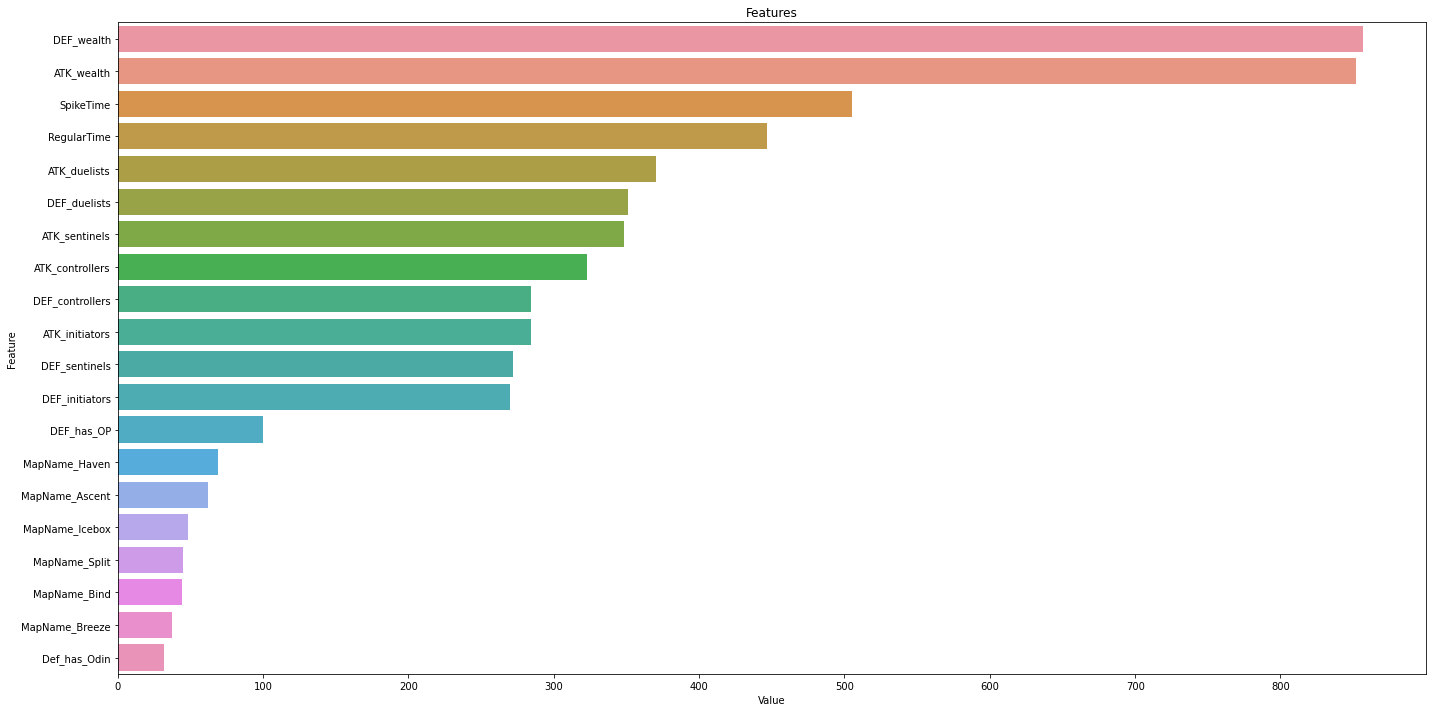

In [19]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Features')
plt.tight_layout()
plt.show()

# <font color='blue'>MODEL PRECISION </font>

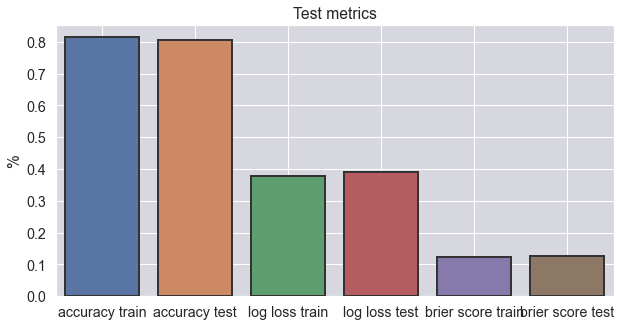

Wall time: 4.51 s


In [20]:
%%time
plt.figure(figsize = (10,5))

pred_proba = model.predict_proba(X_train)
pred_proba_test = model.predict_proba(X_test)

gmt = ["accuracy train", "accuracy test", "log loss train", "log loss test", "brier score train", "brier score test"]
metrics = {'Labels': gmt,
           'Value': [model.score(X_train, Y_train), model.score(X_test, Y_test),
                     log_loss(Y_train, pred_proba),log_loss(Y_test, pred_proba_test),
                     brier_score_loss(Y_train, pd.DataFrame(pred_proba)[1]),brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])]
           }

sns.set_context(rc = {'patch.linewidth': 2.0})
sns.set(font_scale=1.3)
ax = sns.barplot(x='Labels', y='Value', data=metrics, linewidth=2.0, edgecolor=".2", zorder=3, palette=sns.color_palette("deep"))

plt.ylabel('%')
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.grid(linewidth=1, color='white', zorder=0)
ax.set_facecolor("#d7d7e0")
plt.title("Test metrics")
plt.show()

In [ ]:
print("Brier score → {}".format(brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])))


# <font color='blue'>REALIBITY CURVE </font>

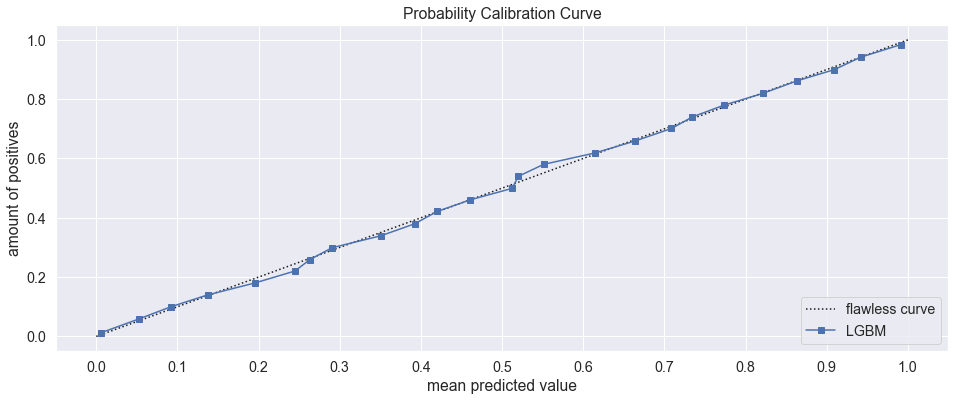

Wall time: 169 ms


Text(0.5, 0, 'mean predicted value')

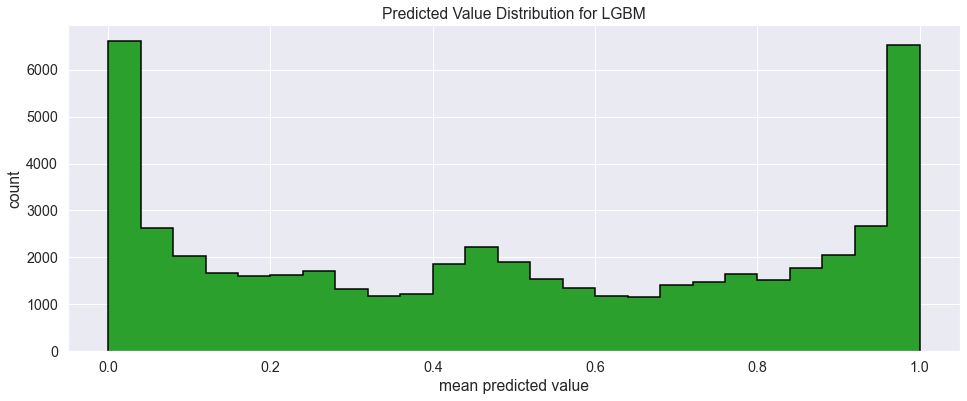

In [21]:
%%time
plt.figure(figsize=(16,6))
plt.plot([0,1], [0,1], 'k:', label='flawless curve')
x, y = calibration_curve(Y_test, pd.DataFrame(pred_proba_test)[1], n_bins=25)
plt.plot(x, y, 's-', label='LGBM')
plt.legend(loc='lower right')
plt.title('Probability Calibration Curve')
plt.ylabel('amount of positives')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(16,6))
plt.hist(pd.DataFrame(pred_proba_test)[1], range=(0,1), bins=25, histtype="step", lw=2, fill=True, color='tab:green',
        edgecolor='black', linewidth=1.5)
plt.title('Predicted Value Distribution for LGBM')
plt.ylabel('count')
plt.xlabel('mean predicted value')

# <font color='blue'>CONFUSION MATRIX </font>

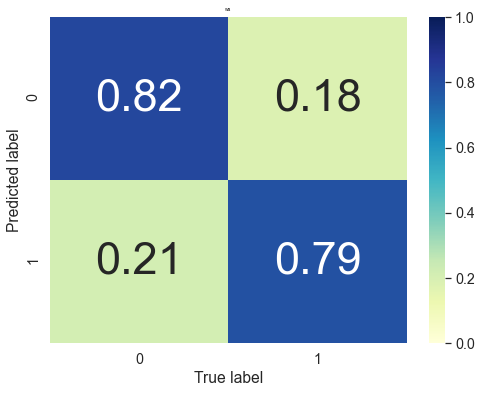

In [22]:
plt.figure(figsize = (8,6))
cm = confusion_matrix(Y_test, model.predict(X_test, num_iteration=50))
cm = (cm/cm.sum(axis=1).reshape(-1,1))

sns.heatmap(cm, cmap="YlGnBu", vmin=0., vmax=1., annot=True, annot_kws={'size':45})
plt.title("wa", fontsize = 5)
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

In [ ]:
Y_pred = model.predict(X_test)
classification_report(Y_test, Y_pred, output_dict=True)["weighted avg"]["f1-score"]